## Оптимальное статистическое оценивание 

#### Схема:  $$\xi = Mf + \nu$$

Оценка $f$

$$\hat f = F M^{*} \left( M F M^{*} + \Sigma \right)^{-1} \cdot \left( \xi - M f_0 \right) + f_0$$

$$\text{где} \; \nu \sim (0, \Sigma), n \sim (n_0, F)$$ 

$$F = exp(-(h_i - h_j) / h_0)$$

In [1]:
# imports
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

sys.path.insert(1, '../scripts')

In [2]:
from direct_measurements import DirectMeasurements
from profile_recovery import ProfileRec

In [3]:
@dataclass
class Bayesan:
    profile: str
    profile_path: str
    dataset_name: str = "dataset_2_csv"

    def assessment(self, sigma, n):
        """Calculation of the optimal statistical estimate."""
        # get data: xi == \xi, M == M(matrix(21x21)), h == heights 
        xi, M, h = self.get_data(sigma, n)
        h_0 = 300
        F = np.array(
            [[2.71828182846 ** (-(h[i] - h[j]) / h_0) for j in range(n)] for i in range(n)]
        )
        # f_0 is average f counted in real profiles
        f_0 = np.array(
            [
                218828033097.85452,
                218828033097.85452,
                233222198201.50778,
                240869305919.3713,
                233147153558.65063,
                245992817730.96088,
                277334885877.20416,
                253690429132.74435,
                210509483053.2839,
                207623473158.38232,
                201501869888.8321,
                154067511300.47278,
                111920619010.35011,
                96210357502.2361,
                62606196195.83074,
                33057684161.768467,
                22882882698.69665,
                13839726552.517252,
                8702834142.601583,
                5583984155.379506,
                5715754433.481799,
            ]
        )
        # out is our evalution
        out = F @ M.T @ np.linalg.inv(M @ F @ M.T) @ (xi - M @ f_0) + f_0
        return h, out

    def get_data(self, sigma, n=21):
        dir_meas = DirectMeasurements(self.profile, sigma, self.dataset_name, self.profile_path)
        prof_recovery = ProfileRec(self.profile, self.profile_path, self.dataset_name)
        data = prof_recovery.make_data(n)
        return (
            np.array([x[1] for x in dir_meas.direct_measurements_for_profile()]),
            np.array(data[1]),
            np.array(data[0]),
        )

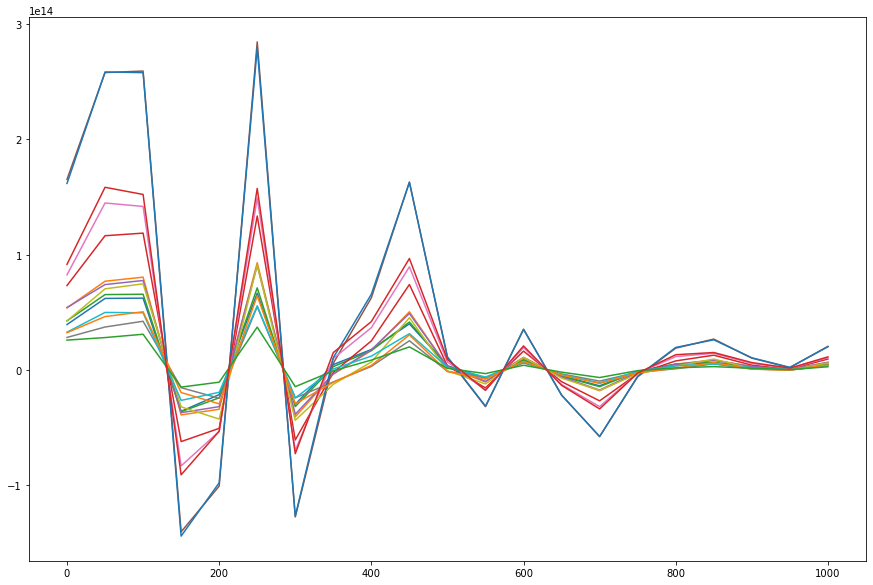

In [4]:
plt.figure(figsize=(15, 10))
dataset_name = "dataset_2_csv"
dir_profiles_name = "profiles_1"
path_to_profile_csv = Path(Path.cwd().parent, "data", dir_profiles_name, "csv")
for txt_path in path_to_profile_csv.glob("*"):
    dir_meas = DirectMeasurements(txt_path.name, 0.3, dataset_name, dir_profiles_name)
    with open(Path(path_to_profile_csv, txt_path.name)) as csv_file:
        reader = csv.reader(csv_file)
        tup_coords: tuple[tuple[str]] = tuple(reader)
        original_x = tuple(float(x[0]) for x in tup_coords)
        original_y = tuple(float(x[1]) for x in tup_coords)
        data_bars = dir_meas.generate_bars([50 * i for i in range(21)], original_x, original_y)
    b = Bayesan(txt_path.name, "profiles_1")
    h, out = b.assessment(sigma=0.1, n=21)
    plt.plot(h, out)
plt.show()